In [1]:
from gurobipy import Model, GRB, quicksum

In [2]:
import nbimporter
from fct_usuelles import lire_graphe, afficher_graphe, visualiser_graphe_par_etape

# Problème **GBP-IP** (Graph Burning Problem - Integer Program) avec **Gurobi**

---

### **Variables du problème :**
- $x_{v, i}$ : une variable binaire qui vaut 1 si le sommet $v \in V$ est le $i$-ème feu dans la séquence de brûlage, et 0 sinon.

---

### **Contraintes :**

1. **(6)** Chaque sommet $v$ ne peut apparaître **qu'une seule fois** dans la séquence :
   $$
   \sum_{i=1}^B x_{v, i} \leq 1, \quad \forall v \in V
   $$

2. **(7)** À chaque position $i$ dans la séquence (1 à $B$), il doit y avoir **exactement un sommet** assigné :
   $$
   \sum_{v \in V} x_{v, i} = 1, \quad \forall i \in \{1, 2, \dots, B\}
   $$

3. **(8)** Chaque sommet $v$ doit être **couvert** (brûlé) au plus tard à l'étape $B$ :
   $$
   \sum_{i=1}^B \sum_{u \in V : v \in N_{B-i}[u]} x_{u, i} \geq 1, \quad \forall v \in V
   $$
   où $N_{B-i}[u]$ est le voisinage étendu autour du sommet $u$ avec une distance $B-i$.


### **Explications :**
1. **Données d'entrée** :
   - `V` : Liste des sommets du graphe.
   - `B` : Longueur maximale de la séquence.
   - `N` : Dictionnaire représentant les voisins étendus \( N_{B-i}[u] \) pour un sommet \( u \).

2. **Variables** :
   - `x[v, i]` : Variables binaires créées avec `addVars`.

3. **Contraintes** :
   - `(6)` : Chaque sommet \( v \) apparaît au plus une fois.
   - `(7)` : Chaque position \( i \) de la séquence contient exactement un sommet.
   - `(8)` : Chaque sommet \( v \) est "couvert" par au moins un feu à l'étape \( i \).

4. **Optimisation** :
   - La fonction objectif est laissée vide (à compléter selon le problème).

---

### **Résultat attendu :**
Après exécution, le programme affichera quels sommets \( v \) sont brûlés à quelles étapes \( i \).

---

Si tu as des précisions sur le graphe ou sur les critères d'optimisation, je peux t'aider à adapter le modèle. 😊

In [3]:
# 10 noeuds
#fichier = 'instances\Stranke94\Stranke94.mtx'

# 29 noeuds
#fichier = 'instances/bn-mouse_visual-cortex_1/bn-mouse_visual-cortex_1.edges'

# 34 noeuds
fichier = 'instances/karate/karate.mtx'

# 7000 noeuds
#fichier = 'instances/fb-pages-government/fb-pages-government.edges'

graphe = lire_graphe(fichier)

In [4]:
# Fonction pour calculer N_{B-i}[u]
def calculer_voisinage_etendu(graphe, u, distance):
    """
    Calcule le voisinage étendu à une distance donnée autour du sommet u.
    :param graphe: Liste d'adjacence du graphe.
    :param u: Sommet de départ.
    :param distance: Rayon du voisinage (nombre maximum d'arêtes).
    :return: Ensemble des sommets atteignables à partir de u dans la distance donnée.
    """
    voisins = {u}
    frontiere = {u}

    for _ in range(distance):
        nouveaux_voisins = set()
        for v in frontiere:
            nouveaux_voisins.update(graphe.get(v, []))
        frontiere = nouveaux_voisins - voisins
        voisins.update(nouveaux_voisins)

        if not frontiere:
            break

    return voisins

In [5]:
# Paramètres du modèle
V = list(graphe.keys())  # Sommets du graphe
B = round(len(V) ** 0.5)  # Longueur maximale de la séquence de brûlage

In [6]:
# Création du modèle
model = Model("GBP-IP")

# Variables : x[v, i] pour chaque sommet v et étape i
x = model.addVars(V, range(1, B+1), vtype=GRB.BINARY, name="x")

# Contrainte (6) : Chaque sommet apparaît au plus une fois dans la séquence
for v in V:
    model.addConstr(quicksum(x[v, i] for i in range(1, B+1)) <= 1, f"once_{v}")

# Contrainte (7) : Chaque position i de la séquence a exactement un sommet
for i in range(1, B+1):
    model.addConstr(quicksum(x[v, i] for v in V) == 1, f"position_{i}")

# Contrainte (8) : Chaque sommet doit être brûlé au plus tard à l'étape B
for v in V:
    model.addConstr(quicksum(
        quicksum(x[u, i] for u in calculer_voisinage_etendu(graphe, v, B-i))  # Voisins pouvant brûler v
        for i in range(1, B+1)
    ) >= 1, f"cover_{v}")

# Fonction objectif : (Non spécifiée dans le problème, on cherche à couvrir tous les sommets)
model.setObjective(0, GRB.MINIMIZE)  # On peut ajouter un critère si nécessaire

# Résolution du modèle
model.optimize()

Set parameter Username
Set parameter LicenseID to value 2601900
Academic license - for non-commercial use only - expires 2025-12-18
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 74 rows, 204 columns and 4642 nonzeros
Model fingerprint: 0xc5c8cdd9
Variable types: 0 continuous, 204 integer (204 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap

In [7]:
# Affichage des résultats
if model.status == GRB.OPTIMAL:
    print("Solution optimale trouvée :")
    chemin = []  # Liste pour enregistrer les sommets brûlés à chaque étape
    for i in range(1, B+1):
        for v in V:
            if x[v, i].x > 0.5:  # Vérifier si x[v, i] est actif
                chemin.append(v)  # Ajouter le sommet et l'étape au chemin
                print(f"Le sommet {v} est brûlé à l'étape {i}")
    
    print("Chemin trouvé :", chemin)  # Afficher la séquence complète des sommets brûlés
else:
    print("Pas de solution optimale trouvée.")


Solution optimale trouvée :
Le sommet 21 est brûlé à l'étape 1
Le sommet 32 est brûlé à l'étape 2
Le sommet 3 est brûlé à l'étape 3
Le sommet 29 est brûlé à l'étape 4
Le sommet 18 est brûlé à l'étape 5
Le sommet 16 est brûlé à l'étape 6
Chemin trouvé : [21, 32, 3, 29, 18, 16]


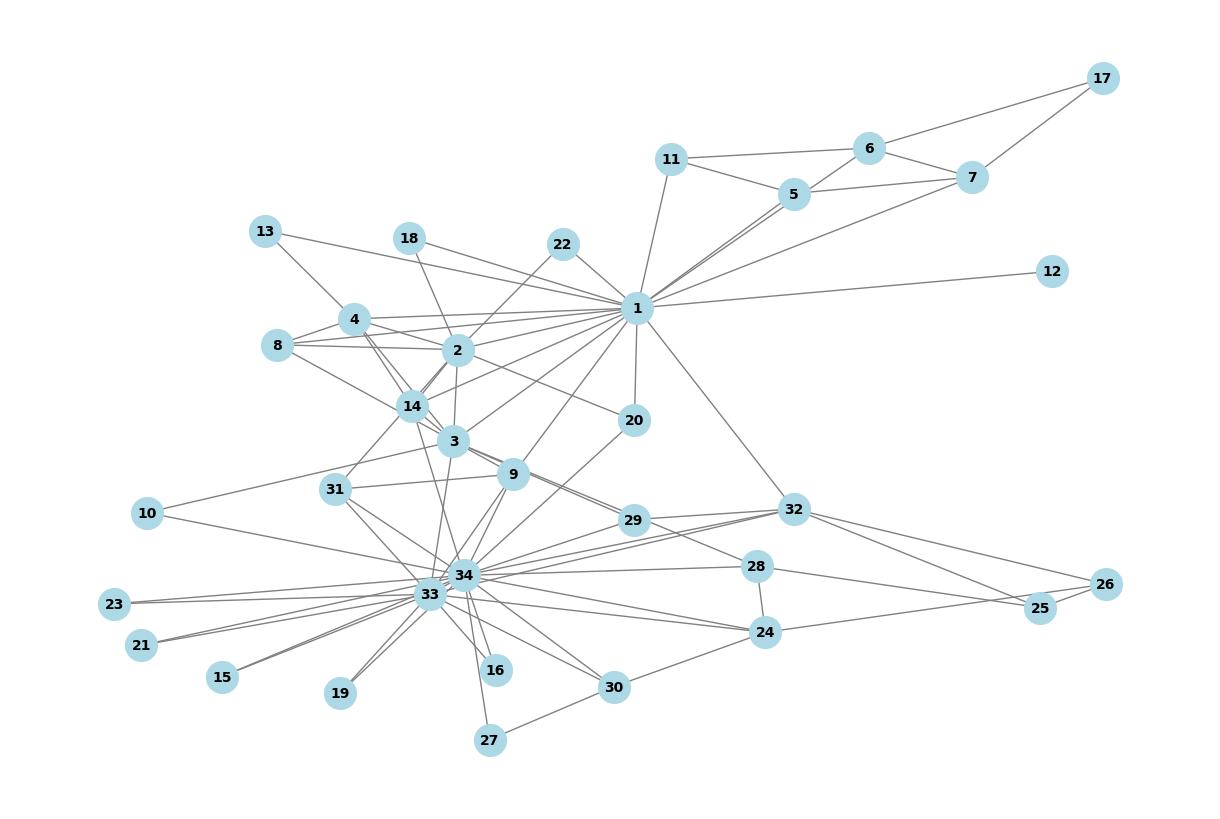

In [8]:
afficher_graphe(fichier)

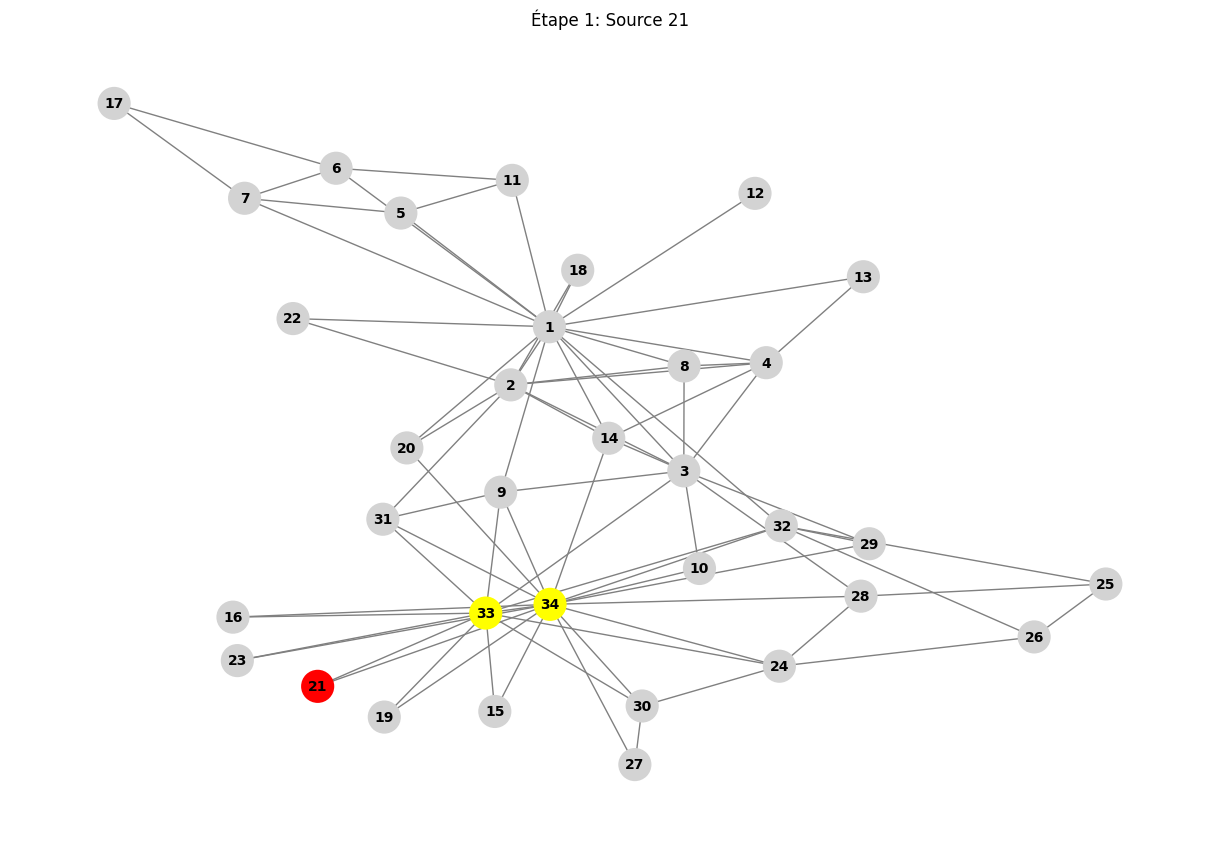

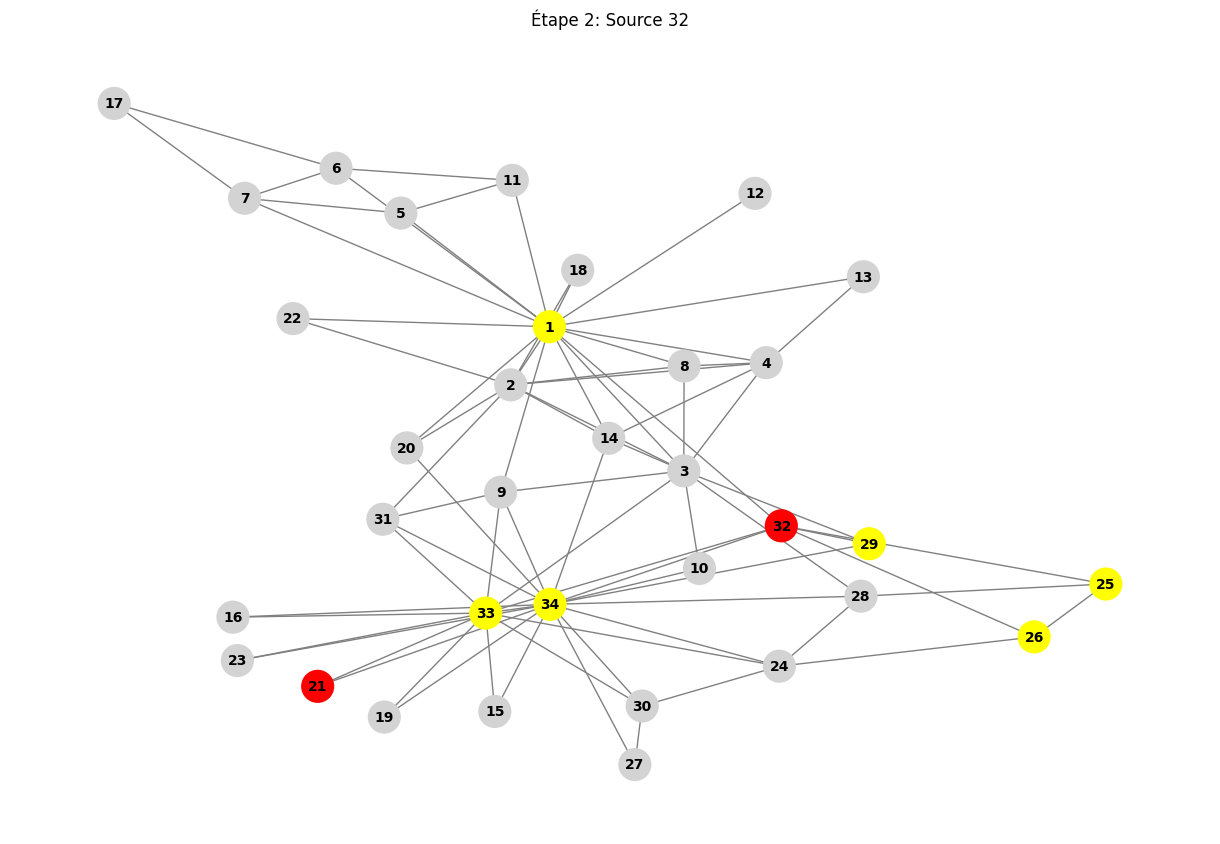

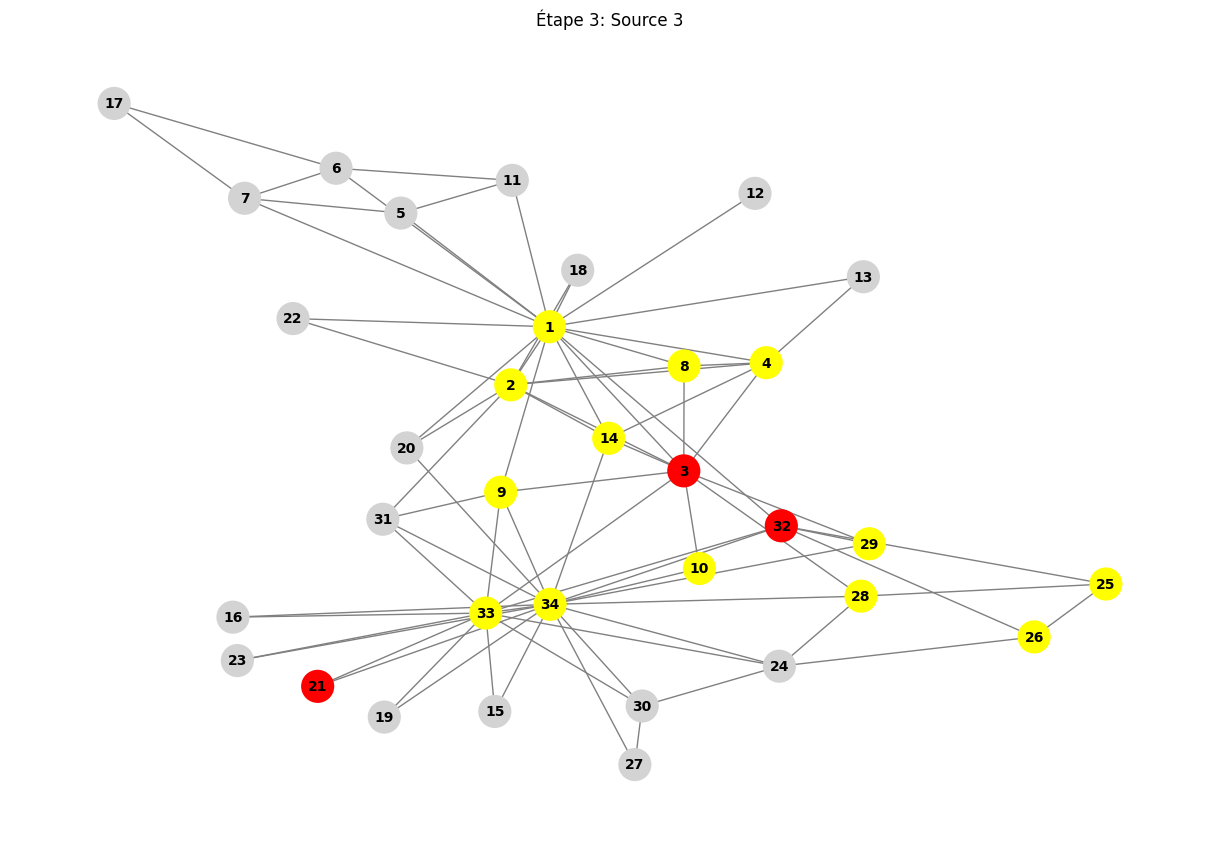

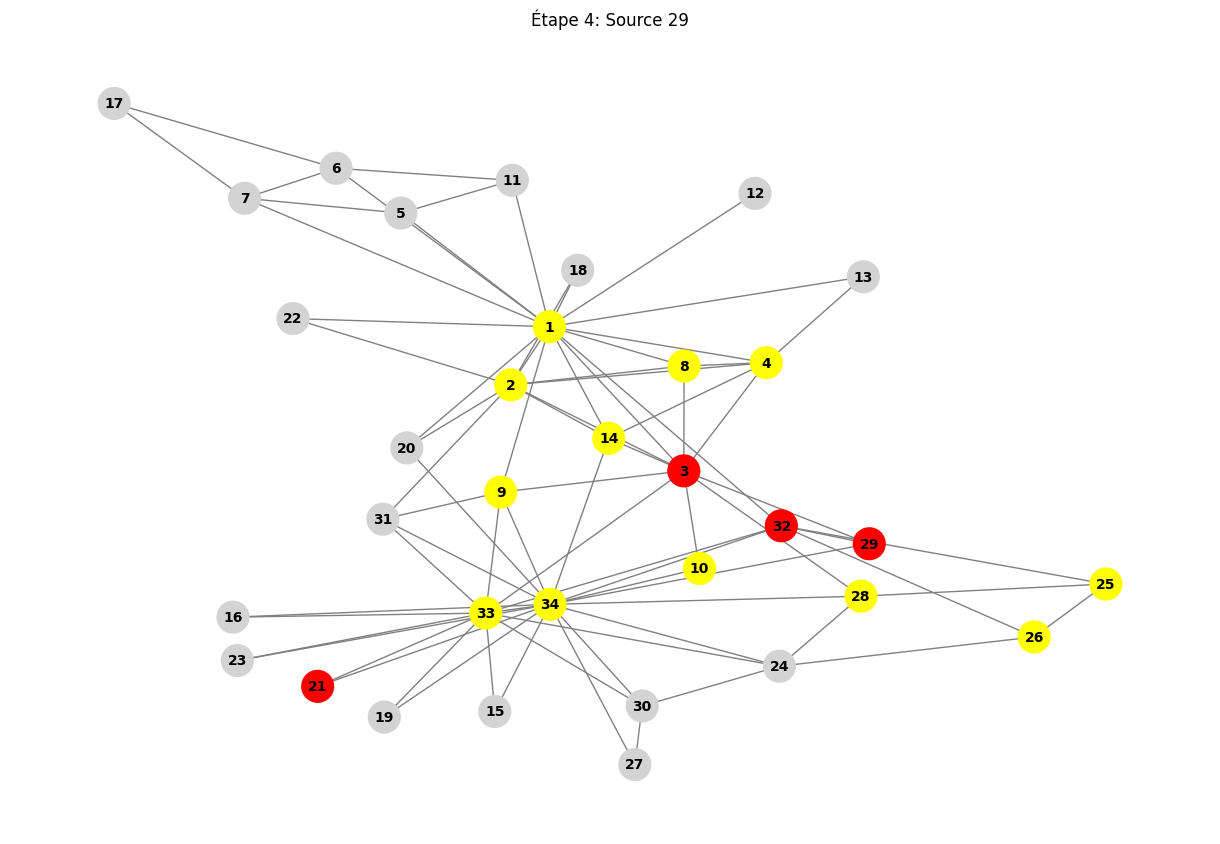

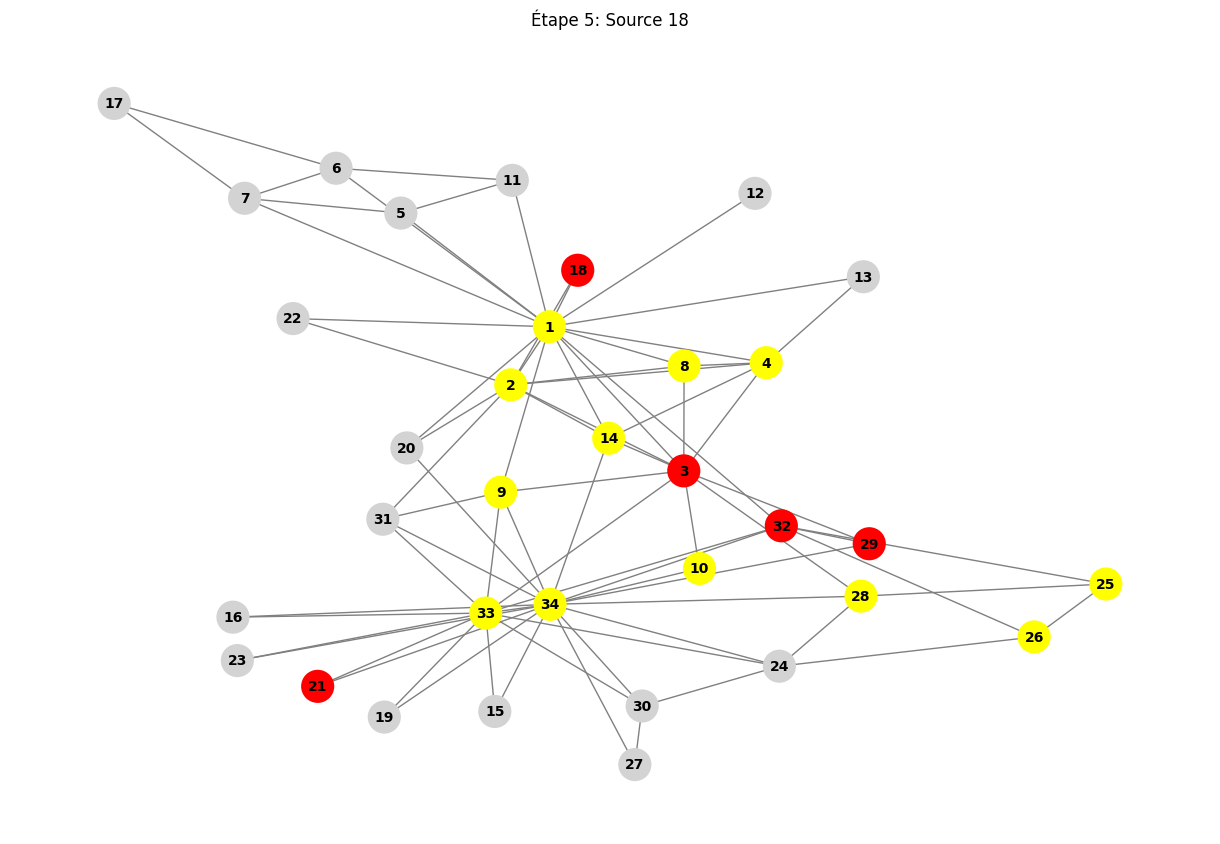

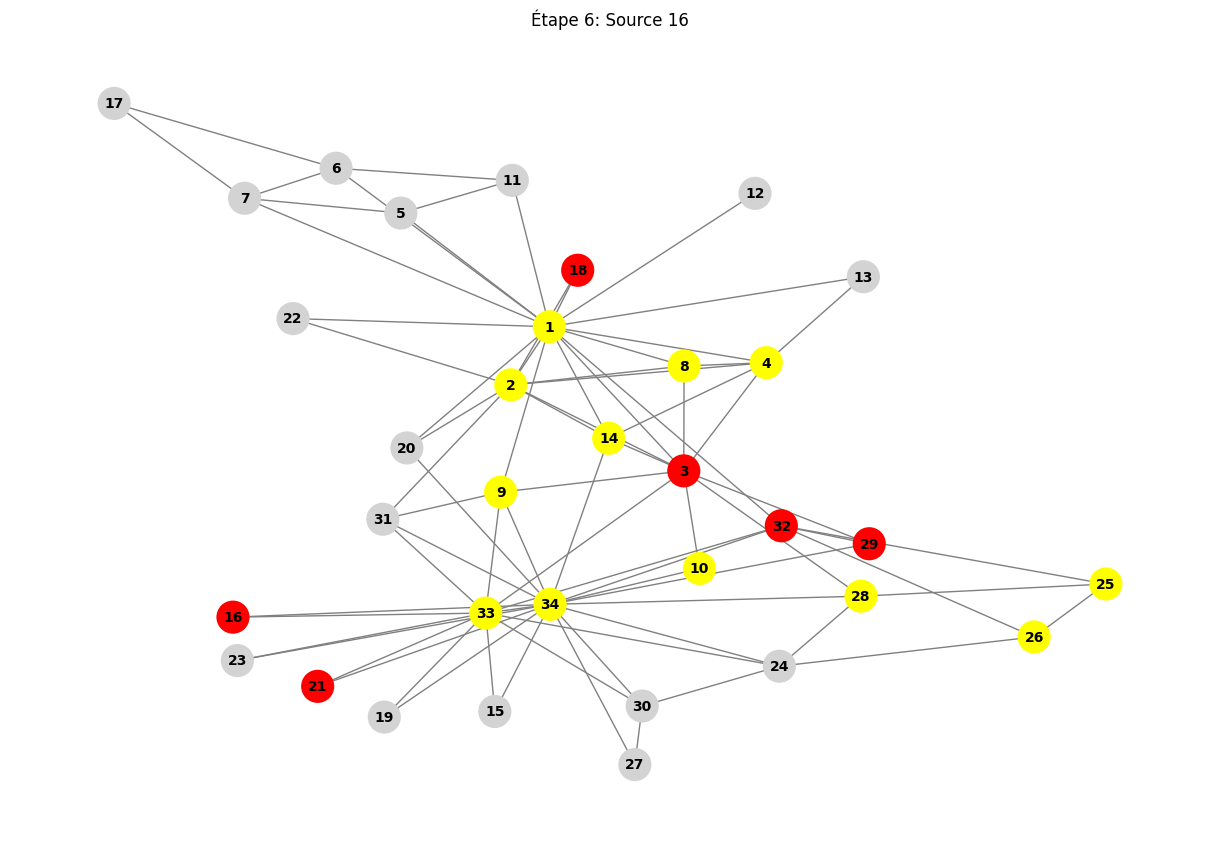

In [9]:
graphe = lire_graphe(fichier)

# Chemin trouvé
#chemin = [21, 32, 3, 29, 18, 16]

# Visualiser le graphe par étape
visualiser_graphe_par_etape(graphe, chemin)